가장 먼저 확인할 것
1. 각 로그 row 수 확인
2. 전체 기간 길이 (몇 개월?)
3. 사용자 수 확인 (readme: 1k users)

아래의 질문에 대한 답을 하면서 파악해나갈 것.
1. 평균 근무 시작 시간은?
2. 평균 파일 copy 수는?
3. USB 사용 분포는?
4. email 발송 분포는?
5. heavy tail 존재?

개인별 baseline 존재 여부 확인
- user별 평균
- user별 표준편차
- 전체 평균 대비 user 평균 분산

In [10]:
import pandas as pd
from pathlib import Path
from functools import reduce

DATA_PATH = Path("dataset/r4.2")

# Load each file once with only the columns needed for the whole notebook
logon = pd.read_csv(DATA_PATH / "logon.csv", usecols=["date", "user", "activity", "pc"], parse_dates=["date"])

# Column names (from loaded dfs)
print(f"logon.csv columns: {logon.columns.tolist()}")

logon.csv columns: ['date', 'user', 'pc', 'activity']


In [11]:
logon.head()

,date,user,pc,activity
0,2010-01-02 06:49:00,NGF0157,PC-6056,Logon
1,2010-01-02 06:50:00,LRR0148,PC-4275,Logon
2,2010-01-02 06:53:04,LRR0148,PC-4124,Logon
3,2010-01-02 07:00:00,IRM0931,PC-7188,Logon
4,2010-01-02 07:00:00,MOH0273,PC-6699,Logon


In [12]:
print(f"logon rows: {len(logon):,} rows")
# range of dates
print(f"date range: {logon['date'].min()} to {logon['date'].max()}")
# number of users
print(f"number of users: {logon['user'].nunique()}")
# activity distribution
print("logon.activity:", logon["activity"].value_counts().to_dict())
# number of unique activities
print(f"number of unique activities: {logon['activity'].nunique()}")

logon rows: 854,859 rows
date range: 2010-01-02 06:49:00 to 2011-05-17 06:43:35
number of users: 1000
logon.activity: {'Logon': 470591, 'Logoff': 384268}
number of unique activities: 2


In [13]:
# --- 1. Work start/end clock time vs work duration ---
logon_events = logon.copy()
logon_events["date_only"] = logon_events["date"].dt.date
logon_events["time_min"] = logon_events["date"].dt.hour * 60 + logon_events["date"].dt.minute

# First Logon per (user, day) = work start time
logon_only = logon_events[logon_events["activity"].str.contains("Logon", case=False, na=False)]
first_logon = logon_only.sort_values("date").groupby(["user", "date_only"]).first().reset_index()
first_logon = first_logon.rename(columns={"time_min": "start_time_min", "pc": "start_pc"})[["user", "date_only", "start_time_min", "start_pc"]]

# Last Logoff per (user, day) = work end time
logoff_only = logon_events[logon_events["activity"].str.contains("Logoff", case=False, na=False)]
last_logoff = logoff_only.sort_values("date").groupby(["user", "date_only"]).last().reset_index()
last_logoff = last_logoff.rename(columns={"time_min": "end_time_min", "pc": "end_pc"})[["user", "date_only", "end_time_min", "end_pc"]]

# Duration only for days with both start and end; if end < start, add 24h (cross-midnight)
daily = first_logon.merge(last_logoff, on=["user", "date_only"], how="inner")
daily["duration_min"] = daily["end_time_min"] - daily["start_time_min"]
daily.loc[daily["duration_min"] < 0, "duration_min"] += 24 * 60

# PC usage per user-day: how many distinct PCs used that day
pcs_per_user_day = logon_events.groupby(["user", "date_only"])["pc"].nunique().reset_index(name="n_pcs")
daily = daily.merge(pcs_per_user_day, on=["user", "date_only"], how="left")
daily["same_pc_start_end"] = daily["start_pc"] == daily["end_pc"]

def min_to_clock(m):
    """Convert minutes (0-1440) to 'HH:MM' clock string."""
    m = int(round(m))
    h, m = m // 60, m % 60
    return f"{h:02d}:{m:02d}"

# Stats
mean_start_min = first_logon["start_time_min"].mean()
std_start_min = first_logon["start_time_min"].std()
mean_end_min = last_logoff["end_time_min"].mean()
std_end_min = last_logoff["end_time_min"].std()
mean_duration_min = daily["duration_min"].mean()
std_duration_min = daily["duration_min"].std()

print("=== 1. Work clock time vs work duration ===")
print()
print("  [ Clock time ]")
print(f"  Mean work start time: {min_to_clock(mean_start_min)}")
print(f"  Mean work end time:   {min_to_clock(mean_end_min)}")
print(f"  Std of work start time: {std_start_min:.1f} min")
print(f"  Std of work end time:   {std_end_min:.1f} min")
print()
print("  [ Work duration ]")
print(f"  Mean work duration: {mean_duration_min:.1f} min (~{mean_duration_min/60:.2f} hr)")
print(f"  Std of work duration: {std_duration_min:.1f} min (~{std_duration_min/60:.2f} hr)")
print()
print(f"  (Based on {len(daily):,} user-days with both first Logon and last Logoff)")
print()
print("  [ PC usage per user-day ]")
print(f"  User-days with exactly 1 PC:  {(daily['n_pcs'] == 1).sum():,} ({(daily['n_pcs'] == 1).mean() * 100:.1f}%)")
print(f"  User-days with 2+ PCs:        {(daily['n_pcs'] >= 2).sum():,} ({(daily['n_pcs'] >= 2).mean() * 100:.1f}%)")
print(f"  User-days with 3+ PCs:        {(daily['n_pcs'] >= 3).sum():,}")
print(f"  Same PC at start and end:     {daily['same_pc_start_end'].sum():,} ({daily['same_pc_start_end'].mean() * 100:.1f}%)")
# Per-PC duration on each user-day (for 2+ PC days: how time is split)
first_per_pc = logon_only.sort_values("date").groupby(["user", "date_only", "pc"]).first().reset_index()[["user", "date_only", "pc", "time_min"]].rename(columns={"time_min": "start_min"})
last_per_pc = logoff_only.sort_values("date").groupby(["user", "date_only", "pc"]).last().reset_index()[["user", "date_only", "pc", "time_min"]].rename(columns={"time_min": "end_min"})
duration_per_pc = first_per_pc.merge(last_per_pc, on=["user", "date_only", "pc"], how="inner")
duration_per_pc["duration_min"] = duration_per_pc["end_min"] - duration_per_pc["start_min"]
duration_per_pc.loc[duration_per_pc["duration_min"] < 0, "duration_min"] += 24 * 60
n_pcs_per_ud = duration_per_pc.groupby(["user", "date_only"]).size()
multi_pc_days = n_pcs_per_ud[n_pcs_per_ud >= 2].index
if len(multi_pc_days) > 0:
    d2 = duration_per_pc.set_index(["user", "date_only"]).loc[multi_pc_days].reset_index()
    primary = d2.groupby(["user", "date_only"])["duration_min"].max()
    total = d2.groupby(["user", "date_only"])["duration_min"].sum()
    print(f"  On user-days with 2+ PCs: mean time on most-used PC = {primary.mean() / 60:.1f} hr, mean total time (all PCs) = {total.mean() / 60:.1f} hr")

=== 1. Work clock time vs work duration ===

  [ Clock time ]
  Mean work start time: 07:57
  Mean work end time:   17:45
  Std of work start time: 68.8 min
  Std of work end time:   94.6 min

  [ Work duration ]
  Mean work duration: 588.6 min (~9.81 hr)
  Std of work duration: 110.9 min (~1.85 hr)

  (Based on 330,268 user-days with both first Logon and last Logoff)

  [ PC usage per user-day ]
  User-days with exactly 1 PC:  303,451 (91.9%)
  User-days with 2+ PCs:        26,817 (8.1%)
  User-days with 3+ PCs:        9,396
  Same PC at start and end:     319,227 (96.7%)
  On user-days with 2+ PCs: mean time on most-used PC = 9.0 hr, mean total time (all PCs) = 9.3 hr


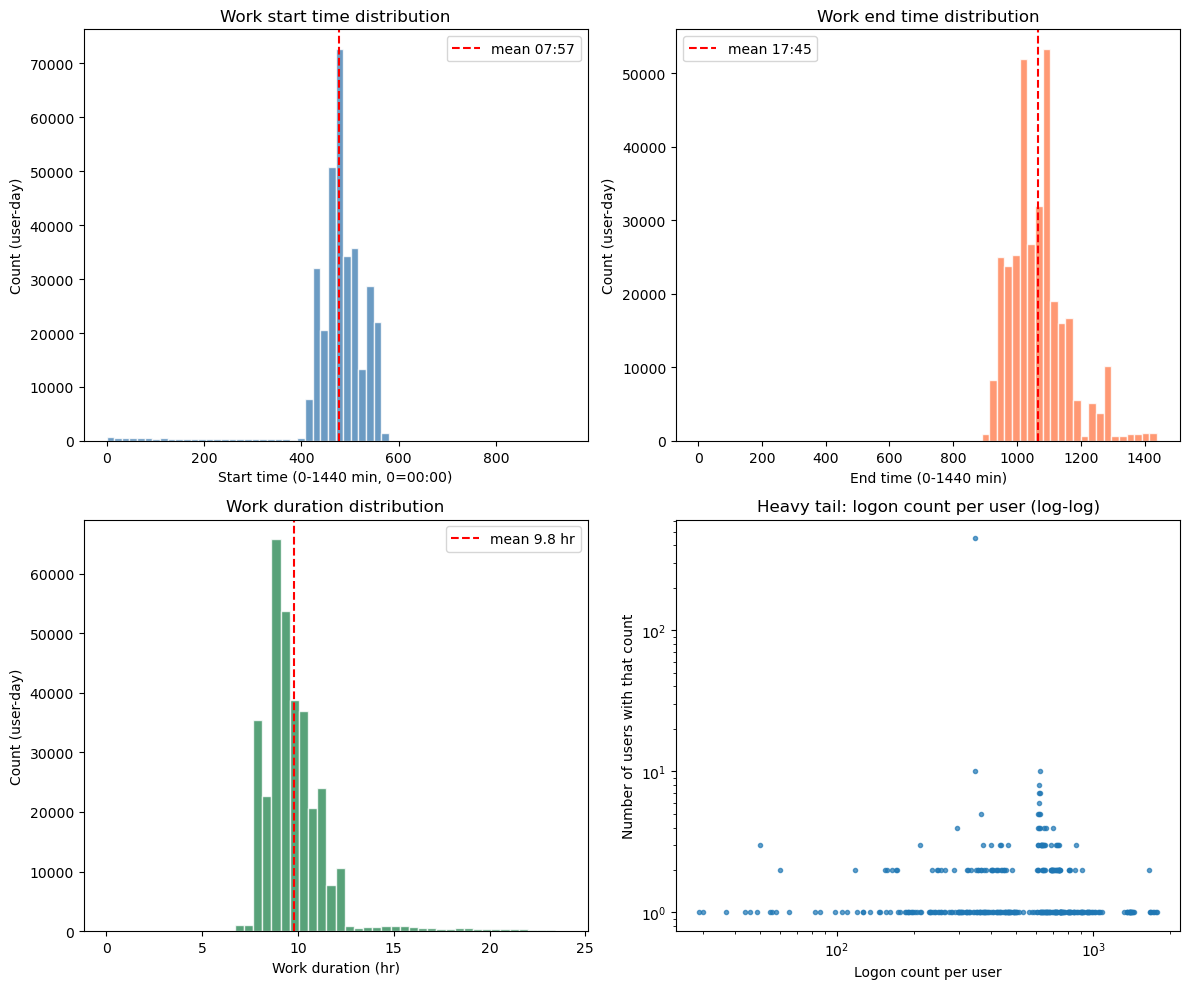

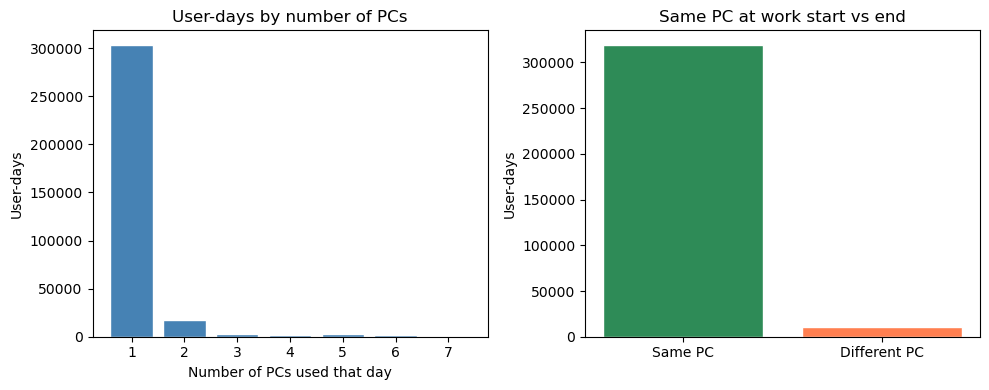

In [14]:
# --- Visualizations ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Work start time distribution (clock time = 0-1440 min)
ax = axes[0, 0]
ax.hist(first_logon["start_time_min"], bins=60, color="steelblue", edgecolor="white", alpha=0.8)
ax.axvline(mean_start_min, color="red", linestyle="--", label=f"mean {min_to_clock(mean_start_min)}")
ax.set_xlabel("Start time (0-1440 min, 0=00:00)")
ax.set_ylabel("Count (user-day)")
ax.set_title("Work start time distribution")
ax.legend()

# 2. Work end time distribution
ax = axes[0, 1]
ax.hist(last_logoff["end_time_min"], bins=60, color="coral", edgecolor="white", alpha=0.8)
ax.axvline(mean_end_min, color="red", linestyle="--", label=f"mean {min_to_clock(mean_end_min)}")
ax.set_xlabel("End time (0-1440 min)")
ax.set_ylabel("Count (user-day)")
ax.set_title("Work end time distribution")
ax.legend()

# 3. Work duration distribution
ax = axes[1, 0]
ax.hist(daily["duration_min"] / 60, bins=50, color="seagreen", edgecolor="white", alpha=0.8)
ax.axvline(mean_duration_min / 60, color="red", linestyle="--", label=f"mean {mean_duration_min/60:.1f} hr")
ax.set_xlabel("Work duration (hr)")
ax.set_ylabel("Count (user-day)")
ax.set_title("Work duration distribution")
ax.legend()

# 4. Heavy tail: logon count per user (log scale)
logon_per_user = logon_only.groupby("user").size()
counts = logon_per_user.value_counts().sort_index()
counts = counts[counts.index > 0]
ax = axes[1, 1]
ax.loglog(counts.index, counts.values, "o", markersize=3, alpha=0.7)
ax.set_xlabel("Logon count per user")
ax.set_ylabel("Number of users with that count")
ax.set_title("Heavy tail: logon count per user (log-log)")

plt.tight_layout()
plt.show()

# PC usage: user-days by number of PCs, and same vs different PC at start/end
fig2, axes2 = plt.subplots(1, 2, figsize=(10, 4))
# Left: distribution of n_pcs per user-day (1, 2, 3, ...)
n_pcs_counts = daily["n_pcs"].value_counts().sort_index()
axes2[0].bar(n_pcs_counts.index.astype(str), n_pcs_counts.values, color="steelblue", edgecolor="white")
axes2[0].set_xlabel("Number of PCs used that day")
axes2[0].set_ylabel("User-days")
axes2[0].set_title("User-days by number of PCs")
# Right: same PC at start and end vs different
same_pc_counts = daily["same_pc_start_end"].value_counts()
axes2[1].bar(["Same PC", "Different PC"], [same_pc_counts.get(True, 0), same_pc_counts.get(False, 0)], color=["seagreen", "coral"], edgecolor="white")
axes2[1].set_ylabel("User-days")
axes2[1].set_title("Same PC at work start vs end")
plt.tight_layout()
plt.show()

# Work start time distribution (좌상단)

### 관찰

* 평균 07:57
* 분포가 400~550분 (06:40~09:10) 근처에 강하게 몰림
* 극단값 거의 없음

### 해석

* 로그인 시작 시간은 강하게 집중되어 있음
* 분산이 매우 크지 않음
* “일반적인 근무 시작 시간 구조”가 뚜렷함

> population-level baseline이 존재함을 보여줌

하지만 더 중요한 건 개인별 분산이 작은지 확인해야함.
(지금은 전체 user-day 분포. 다음 단계는 user별 평균/표준편차를 봐야함)

---

# Work end time distribution (우상단)

### 관찰

* 평균 17:45
* 역시 강하게 집중
* 약간의 오른쪽 tail 존재 (야근)

### 해석

* 퇴근 시간도 구조적으로 안정적
* tail은 있지만 과도하게 두껍지 않음

이건 baseline modeling에 매우 적합한 데이터 구조

---

# Work duration distribution (좌하단)

### 관찰

* 평균 약 9.8시간
* 대체로 8~11시간 사이에 집중
* 약간의 오른쪽 꼬리 (long work days)

### 해석

* 대부분 9~10시간 근무
* 일부 15~20시간 같은 값 존재

생각해봐야할 점
* 특정 직군인가?
* 특정 시점인가?
* 아니면 데이터 오류인가?
(이건 나중에 Deviation-from-Baseline Modeling 할 때 연결해보면 될 듯)

---

# Heavy tail: logon count per user (우하단)

### 관찰

* x축: 사용자별 총 logon 수 (log scale)
* y축: 해당 logon 수를 가진 사용자 수 (log scale)
* 대부분 y=1 근처
* 오른쪽으로 긴 꼬리 존재

### 해석

“전형적인 heavy tail”이라기보다는 사용자 간 활동량 이질성이 매우 큼

즉:

* 어떤 사용자는 매우 많이 로그인
* 대부분은 중간 정도

여기서 중요한 점:

* population 평균 기준은 위험. 개인차가 크니까
* 개인 baseline이 필요

---

# 지금까지 결론
1. 근무 시작/종료 시간은 전체적으로 안정적
2. 근무 시간 길이도 비교적 집중
3. 사용자 간 활동량은 매우 이질적

```
Between-person variance ↑
Within-person variance (추정) ↓
```

deviation-from-self 접근이 매우 타당

---

# 소결

지금 그래프는 Population 구조는 안정적이고, 사용자 간 이질성은 존재한다는 걸 시사.
--> Deviation-from-Baseline Modeling 을 할 수 있는 좋은 신호


지금까지 본 건 전체 user에 대한 평균과 표준편차.</br>

이제 각 user에 대해 아래 사항 확인 필요 </br>
- 평균 시작 시간
- 시작 시간 표준편차
- 평균 근무시간
- 근무시간 표준편차

In [15]:
# Per-user: mean start time, std start time, mean duration, std duration
# (uses first_logon and daily from earlier cells)

per_user_start = first_logon.groupby("user")["start_time_min"].agg(["mean", "std"]).rename(
    columns={"mean": "mean_start_min", "std": "std_start_min"}
)
per_user_duration = daily.groupby("user")["duration_min"].agg(["mean", "std"]).rename(
    columns={"mean": "mean_duration_min", "std": "std_duration_min"}
)
per_user = per_user_start.join(per_user_duration, how="outer")

# Summary of per-user stats (how the four metrics distribute across users)
print("=== Per-user stats (summary across users) ===")
print(per_user.describe())
print()
print("Sample (first 10 users):")
print(per_user.head(10).to_string())
print()

# show as clock time for readability
def min_to_clock(m):
    m = int(round(m))
    h, m = m // 60, m % 60
    return f"{h:02d}:{m:02d}"

per_user_readable = per_user.copy()
per_user_readable["mean_start_clock"] = per_user_readable["mean_start_min"].apply(min_to_clock)
per_user_readable["mean_duration_hr"] = (per_user_readable["mean_duration_min"] / 60).round(2)
print("Per-user metrics (mean start as clock, duration in hr):")
print(per_user_readable[["mean_start_clock", "std_start_min", "mean_duration_hr", "std_duration_min"]].head(10))

=== Per-user stats (summary across users) ===
       mean_start_min  std_start_min  mean_duration_min  std_duration_min
count     1000.000000    1000.000000        1000.000000       1000.000000
mean       476.431912      19.946016         591.101636         28.116468
std         58.682033      36.737820         101.398565         47.833315
min        226.141176       4.529752         424.043353          7.641294
25%        461.989560       5.819866         541.778902          9.776593
50%        477.826590       7.097578         547.214997         12.125422
75%        508.191360       8.221223         608.765063         13.995972
max        555.448864     188.730840         997.649682        240.512279

Sample (first 10 users):
         mean_start_min  std_start_min  mean_duration_min  std_duration_min
user                                                                       
AAE0190      493.534682       6.574453         603.179191         10.960917
AAF0535      538.609756       7.51

In [16]:
mean_within_start = per_user["std_start_min"].mean()
between_start = per_user["mean_start_min"].std()

mean_within_duration = per_user["std_duration_min"].mean()
between_duration = per_user["mean_duration_min"].std()

print("=== Start time variance comparison ===")
print(f"Mean within-user std: {mean_within_start:.2f} min")
print(f"Between-user std of means: {between_start:.2f} min")
print()

print("=== Duration variance comparison ===")
print(f"Mean within-user std: {mean_within_duration:.2f} min")
print(f"Between-user std of means: {between_duration:.2f} min")

=== Start time variance comparison ===
Mean within-user std: 19.95 min
Between-user std of means: 58.68 min

=== Duration variance comparison ===
Mean within-user std: 28.12 min
Between-user std of means: 101.40 min


### Do users stick to one PC or switch over time?

Check whether each user logs on to a single PC (their "own" PC) or uses multiple PCs.

=== Do users use their own PC (single PC) or switch? ===

Total users with at least one Logon: 1000
Users who use exactly 1 PC:  680 (68.0%)
Users who use 2+ PCs:        320 (32.0%)
Users who use 3+ PCs:        217
Max PCs used by any user:    720

--- Distribution: number of PCs per user ---
pc
1      680
2      103
3      112
4        9
5        3
6        2
7        2
8        2
9        2
10       3
12       1
13       1
15       2
17       2
18       1
19       4
20       2
21       5
22       2
26       1
27       2
28       2
29       1
30       2
31       1
32       1
34       2
35       2
36       2
38       1
39       1
40       1
42       1
46       1
48       1
165      1
285      1
289      1
306      1
361      1
368      1
385      1
416      1
447      1
456      1
479      1
490      1
504      1
519      1
540      1
570      1
598      1
604      1
614      1
618      1
620      1
622      1
624      1
625      1
628      1
629      1
630      2
631      1
633      1

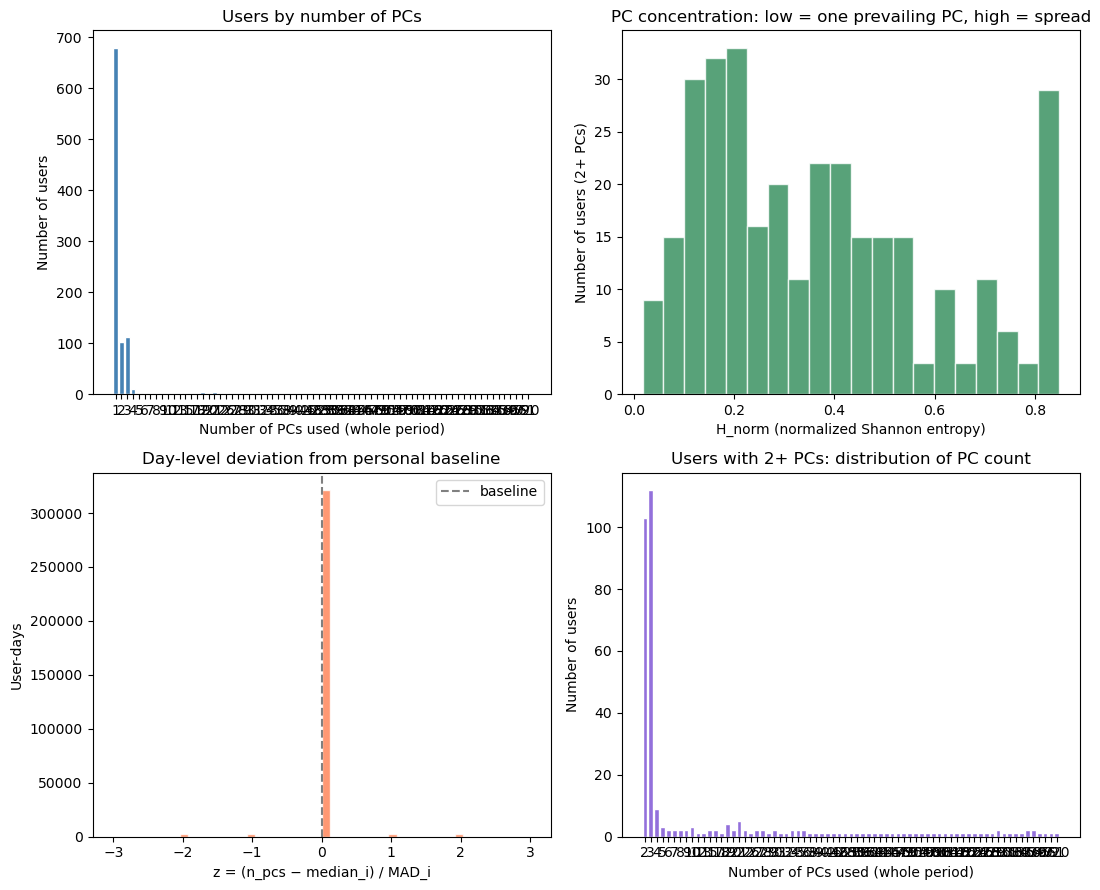

In [29]:
# PCs per user: do users use one PC or many?
logon_only = logon[logon["activity"].str.contains("Logon", case=False, na=False)]
pcs_per_user = logon_only.groupby("user")["pc"].nunique()

print("=== Do users use their own PC (single PC) or switch? ===\n")
print(f"Total users with at least one Logon: {len(pcs_per_user)}")
print(f"Users who use exactly 1 PC:  {(pcs_per_user == 1).sum()} ({(pcs_per_user == 1).mean() * 100:.1f}%)")
print(f"Users who use 2+ PCs:        {(pcs_per_user >= 2).sum()} ({(pcs_per_user >= 2).mean() * 100:.1f}%)")
print(f"Users who use 3+ PCs:        {(pcs_per_user >= 3).sum()}")
print(f"Max PCs used by any user:    {pcs_per_user.max()}")

print("\n--- Distribution: number of PCs per user ---")
print(pcs_per_user.value_counts().sort_index().to_string())

# --- Rigorous metrics (no arbitrary cutoffs) ---
# Vectorized: PC usage distribution per user P(PC_j | user_i)
pc_counts = logon_only.groupby(["user", "pc"]).size()
user_totals = pc_counts.groupby(level="user").transform("sum")
pc_dist = (pc_counts / user_totals).groupby(level="user")

# Primary share: max_j P(PC_j | user_i) — vectorized
primary_share_series = pc_dist.max()

# Shannon entropy H_i = -sum_j p_ij log(p_ij); low = one PC dominant, high = spread
import numpy as np
def entropy_from_probs(p):
    p = np.asarray(p)
    p = p[p > 0]
    return -np.sum(p * np.log(p)) if len(p) > 0 else 0.0

user_entropy = pc_dist.apply(lambda x: entropy_from_probs(x.values))
# Normalized entropy H_norm = H / log(k), 0~1, comparable across users with different k
k_per_user = pc_dist.apply(len)
user_entropy_norm = user_entropy / np.log(k_per_user.clip(lower=1))

# Only for users with 2+ PCs (meaningful for "concentration" interpretation)
multi_pc_users = pcs_per_user[pcs_per_user >= 2].index
primary_share_multi = primary_share_series.reindex(multi_pc_users).dropna()
entropy_multi = user_entropy_norm.reindex(multi_pc_users).dropna()

print("\n--- Among users with 2+ PCs: concentration of PC usage (no fixed cutoffs) ---")
if len(primary_share_multi) > 0:
    print("  Primary share (max P(PC|user)): mean {:.2%}, median {:.2%}".format(primary_share_multi.mean(), primary_share_multi.median()))
    print("  Normalized entropy H_norm (0=one PC dominant, 1=uniform): mean {:.3f}, median {:.3f}".format(entropy_multi.mean(), entropy_multi.median()))
    print("  → Low H_norm: one prevailing PC; high H_norm: PCs used more equally.")

# Day-level: deviation from personal baseline (median, MAD) — no 50%/20% cutoffs
user_median_npcs = daily.groupby("user")["n_pcs"].median()
user_mad_npcs = daily.groupby("user")["n_pcs"].apply(lambda x: np.median(np.abs(x - x.median())))
# MAD=0 (constant n_pcs) → deviation = 0
merge_med = daily[["user", "date_only", "n_pcs"]].merge(
    user_median_npcs.rename("median_npcs"), left_on="user", right_index=True
).merge(
    user_mad_npcs.rename("mad_npcs"), left_on="user", right_index=True
)
merge_med["z_npcs"] = np.where(merge_med["mad_npcs"] > 0,
    (merge_med["n_pcs"] - merge_med["median_npcs"]) / merge_med["mad_npcs"], 0)
z_npcs = merge_med[["user", "date_only", "n_pcs", "median_npcs", "mad_npcs", "z_npcs"]]

print("\n--- Day-level multi-PC: deviation from personal baseline (z = (n_pcs - median_i) / MAD_i) ---")
print("  Per-user median n_pcs (baseline): mean {:.2f}, median {:.1f}".format(user_median_npcs.mean(), user_median_npcs.median()))
print("  Day-level z (positive = more PCs than usual for that user): mean {:.2f}, std {:.2f}".format(z_npcs["z_npcs"].mean(), z_npcs["z_npcs"].std()))
print("  → Habitual multi-PC users have high baseline median; occasional users show up as high z on some days.")

# --- Intuitive (cutoff-based) summary for readability ---
print("\n--- Intuitive summary (cutoff-based, for quick reading) ---")
if len(primary_share_multi) > 0:
    prevailing = (primary_share_multi >= 0.7).sum()
    mixed = ((primary_share_multi >= 0.5) & (primary_share_multi < 0.7)).sum()
    equal = (primary_share_multi < 0.5).sum()
    print("  Among users with 2+ PCs — primary share: ≥70% on one PC: {}, 50–70%: {}, <50% (spread): {}.".format(prevailing, mixed, equal))
user_total_days = daily.groupby("user").size()
user_multi_pc_days = daily[daily["n_pcs"] >= 2].groupby("user").size()
users_with_any_multi = user_multi_pc_days.index
if len(users_with_any_multi) > 0:
    frac_multi_pc_days = user_multi_pc_days / user_total_days.reindex(users_with_any_multi).fillna(1)
    habitual = (frac_multi_pc_days >= 0.5).sum()
    special = (frac_multi_pc_days < 0.2).sum()
    print("  Among users with ≥1 two-PC day — ≥50% of days are 2+ PC: {} users; <20% of days: {} users.".format(habitual, special))

# --- Visualizations ---
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(11, 9))

# 1. Users by number of PCs (1, 2, 3, ...)
ax = axes[0, 0]
pcs_counts = pcs_per_user.value_counts().sort_index()
ax.bar(pcs_counts.index.astype(str), pcs_counts.values, color="steelblue", edgecolor="white")
ax.set_xlabel("Number of PCs used (whole period)")
ax.set_ylabel("Number of users")
ax.set_title("Users by number of PCs")

# 2. Normalized entropy (users with 2+ PCs): 0 = one dominant PC, 1 = uniform
ax = axes[0, 1]
if len(entropy_multi) > 0:
    ax.hist(entropy_multi, bins=20, color="seagreen", edgecolor="white", alpha=0.8)
    ax.set_xlabel("H_norm (normalized Shannon entropy)")
    ax.set_ylabel("Number of users (2+ PCs)")
    ax.set_title("PC concentration: low = one prevailing PC, high = spread")
else:
    ax.text(0.5, 0.5, "No users with 2+ PCs", ha="center", va="center", transform=ax.transAxes)
    ax.set_title("PC concentration (entropy)")

# 3. Day-level z: deviation from personal baseline (n_pcs vs median_i)
ax = axes[1, 0]
z_vals = z_npcs["z_npcs"]
ax.hist(z_vals, bins=50, color="coral", edgecolor="white", alpha=0.8)
ax.axvline(0, color="gray", linestyle="--", label="baseline")
ax.set_xlabel("z = (n_pcs − median_i) / MAD_i")
ax.set_ylabel("User-days")
ax.set_title("Day-level deviation from personal baseline")
ax.legend()

# 4. Among users with 2+ PCs: distribution of how many PCs they use
ax = axes[1, 1]
pcs_multi = pcs_per_user[pcs_per_user >= 2]
if len(pcs_multi) > 0:
    pcs_multi_counts = pcs_multi.value_counts().sort_index()
    ax.bar(pcs_multi_counts.index.astype(str), pcs_multi_counts.values, color="mediumpurple", edgecolor="white")
    ax.set_xlabel("Number of PCs used (whole period)")
    ax.set_ylabel("Number of users")
    ax.set_title("Users with 2+ PCs: distribution of PC count")
else:
    ax.text(0.5, 0.5, "No users with 2+ PCs", ha="center", va="center", transform=ax.transAxes)
    ax.set_title("Users with 2+ PCs: distribution of PC count")

plt.tight_layout()
plt.show()

In [30]:
u_max = pcs_per_user.idxmax()
pcs_per_user.loc[u_max], u_max

logon_only.loc[logon_only["user"] == u_max, "pc"].dropna().astype(str).unique()[0:100]

array(['PC-9842', 'PC-2173', 'PC-7052', 'PC-4633', 'PC-9714', 'PC-7236',
       'PC-9094', 'PC-9643', 'PC-1677', 'PC-7879', 'PC-3683', 'PC-7595',
       'PC-6933', 'PC-3932', 'PC-7206', 'PC-0330', 'PC-7445', 'PC-7082',
       'PC-9268', 'PC-8591', 'PC-4547', 'PC-9184', 'PC-7311', 'PC-3378',
       'PC-8989', 'PC-6194', 'PC-2417', 'PC-5647', 'PC-9850', 'PC-6264',
       'PC-8610', 'PC-4704', 'PC-6824', 'PC-5977', 'PC-0252', 'PC-9999',
       'PC-3814', 'PC-6417', 'PC-1069', 'PC-3424', 'PC-8001', 'PC-6380',
       'PC-2896', 'PC-6499', 'PC-8318', 'PC-4032', 'PC-9408', 'PC-6692',
       'PC-0777', 'PC-0164', 'PC-2017', 'PC-5833', 'PC-8252', 'PC-1289',
       'PC-0115', 'PC-2464', 'PC-0741', 'PC-2244', 'PC-0474', 'PC-3379',
       'PC-7558', 'PC-2125', 'PC-0576', 'PC-0728', 'PC-3651', 'PC-5762',
       'PC-8711', 'PC-8493', 'PC-9379', 'PC-6232', 'PC-0467', 'PC-3738',
       'PC-7913', 'PC-1736', 'PC-0191', 'PC-2368', 'PC-2904', 'PC-1165',
       'PC-0623', 'PC-8863', 'PC-8669', 'PC-4040', 

In [31]:
import re

u_max = pcs_per_user.idxmax()

pcs_u = logon_only.loc[logon_only["user"] == u_max, "pc"].dropna().astype(str)

# (1) 유니크 PC 몇 개인지
print("raw unique pcs:", pcs_u.nunique())

# (2) 눈에 안 보이는 문자 확인: repr로 상위 30개만
for s in pcs_u.unique()[:30]:
    print(repr(s), "len=", len(s))

def normalize_pc(s: str) -> str:
    s = str(s)
    s = s.strip().lower()
    # 제어문자 제거
    s = re.sub(r"[\x00-\x1f\x7f-\x9f]", "", s)
    # 혹시 BOM 같은 유니코드 제거
    s = s.replace("\ufeff", "")
    return s

pcs_u_norm = pcs_u.map(normalize_pc)

print("normalized unique pcs:", pcs_u_norm.nunique())


all_pcs = logon_only["pc"].dropna().astype(str).map(normalize_pc)
print("total unique PCs overall:", all_pcs.nunique())

u_max = pcs_per_user.idxmax()
u_pcs = logon_only.loc[logon_only["user"]==u_max, "pc"].dropna().astype(str).map(normalize_pc).nunique()
print("max user unique PCs:", u_pcs, "share:", u_pcs / all_pcs.nunique())

days_u = logon_only.loc[logon_only["user"]==u_max, "date"].nunique()
print("active days for max user:", days_u)

# 하루 평균 몇 대의 PC를 쓰는지(대략)
print("unique PCs / active days:", u_pcs / max(days_u, 1))

raw unique pcs: 720
'PC-9842' len= 7
'PC-2173' len= 7
'PC-7052' len= 7
'PC-4633' len= 7
'PC-9714' len= 7
'PC-7236' len= 7
'PC-9094' len= 7
'PC-9643' len= 7
'PC-1677' len= 7
'PC-7879' len= 7
'PC-3683' len= 7
'PC-7595' len= 7
'PC-6933' len= 7
'PC-3932' len= 7
'PC-7206' len= 7
'PC-0330' len= 7
'PC-7445' len= 7
'PC-7082' len= 7
'PC-9268' len= 7
'PC-8591' len= 7
'PC-4547' len= 7
'PC-9184' len= 7
'PC-7311' len= 7
'PC-3378' len= 7
'PC-8989' len= 7
'PC-6194' len= 7
'PC-2417' len= 7
'PC-5647' len= 7
'PC-9850' len= 7
'PC-6264' len= 7
normalized unique pcs: 720
total unique PCs overall: 1003
max user unique PCs: 720 share: 0.7178464606181456
active days for max user: 1735
unique PCs / active days: 0.414985590778098


In [35]:
# 엄밀한 지표 요약 (위 셀에서 이미 계산된 변수 사용: entropy_multi, z_npcs, user_median_npcs)
# 위쪽 "PCs per user" 셀을 먼저 실행해야 entropy_multi, z_npcs, user_median_npcs 가 정의됨.

print("=" * 60)
print("1. 둘 이상의 PC를 쓰는 사람: 자주 쓰는 PC vs 골고루 사용 (엔트로피 기반)")
print("=" * 60)

if "entropy_multi" in dir() and len(entropy_multi) > 0:
    print(f"  분석 대상: {len(entropy_multi)}명 (전체 기간에서 2대 이상 PC 사용)")
    print(f"  정규화 엔트로피 H_norm (0=한 대 집중, 1=고르게 사용): 평균 {entropy_multi.mean():.3f}, 중앙값 {entropy_multi.median():.3f}")
    print("  [ 해석 ] H_norm이 낮으면 한 대가 지배적, 높으면 여러 대를 골고루 사용 (임의 기준 없음).")
    if "primary_share_multi" in dir() and len(primary_share_multi) > 0:
        prevailing = (primary_share_multi >= 0.7).sum()
        mixed = ((primary_share_multi >= 0.5) & (primary_share_multi < 0.7)).sum()
        equal = (primary_share_multi < 0.5).sum()
        print(f"  [ 직관 ] 한 대 70% 이상: {prevailing}명, 50~70%: {mixed}명, 50% 미만(골고루): {equal}명")
else:
    print("  위쪽 'PCs per user' 셀을 먼저 실행하세요.")

print()
print("=" * 60)
print("2. 하루에 2대 이상 PC를 쓰는 날: 개인 baseline 대비 이탈 (z 점수)")
print("=" * 60)

if "z_npcs" in dir() and len(z_npcs) > 0:
    print("  일별 n_pcs를 사용자별 median, MAD로 표준화: z = (n_pcs − median_i) / MAD_i")
    print(f"  일수준 z 분포: 평균 {z_npcs['z_npcs'].mean():.2f}, 표준편차 {z_npcs['z_npcs'].std():.2f}")
    if "user_median_npcs" in dir():
        print(f"  사용자별 baseline(median n_pcs): 평균 {user_median_npcs.mean():.2f}, 중앙값 {user_median_npcs.median():.1f}")
    print("  [ 해석 ] z>0인 날은 그 사용자에게 '평소보다 PC를 많이 쓴 날'. habitual muti PC 사용자는 baseline이 높고, 가끔만 쓰는 사용자는 일부 날만 z가 큼.")
    # 직관적 요약 (2+ PC 날 비율)
    user_total_days = daily.groupby("user").size()
    user_multi_pc_days = daily[daily["n_pcs"] >= 2].groupby("user").size()
    users_any = user_multi_pc_days.index
    if len(users_any) > 0:
        frac_multi = user_multi_pc_days / user_total_days.reindex(users_any).fillna(1)
        habitual = (frac_multi >= 0.5).sum()
        special = (frac_multi < 0.2).sum()
        print(f"  [ 직관 ] 출근일의 50% 이상이 2대+ PC: {habitual}명, 20% 미만만 2대+ PC: {special}명")
else:
    print("  위쪽 'PCs per user' 셀을 먼저 실행하세요.")

1. 둘 이상의 PC를 쓰는 사람: 자주 쓰는 PC vs 골고루 사용 (엔트로피 기반)
  분석 대상: 320명 (전체 기간에서 2대 이상 PC 사용)
  정규화 엔트로피 H_norm (0=한 대 집중, 1=고르게 사용): 평균 0.370, 중앙값 0.314
  [ 해석 ] H_norm이 낮으면 한 대가 지배적, 높으면 여러 대를 골고루 사용 (임의 기준 없음).
  [ 직관 ] 한 대 70% 이상: 279명, 50~70%: 1명, 50% 미만(골고루): 40명

2. 하루에 2대 이상 PC를 쓰는 날: 개인 baseline 대비 이탈 (z 점수)
  일별 n_pcs를 사용자별 median, MAD로 표준화: z = (n_pcs − median_i) / MAD_i
  일수준 z 분포: 평균 0.00, 표준편차 0.26
  사용자별 baseline(median n_pcs): 평균 1.12, 중앙값 1.0
  [ 해석 ] z>0인 날은 그 사용자에게 '평소보다 PC를 많이 쓴 날'. habitual muti PC 사용자는 baseline이 높고, 가끔만 쓰는 사용자는 일부 날만 z가 큼.
  [ 직관 ] 출근일의 50% 이상이 2대+ PC: 40명, 20% 미만만 2대+ PC: 169명


In [36]:

# 둘 이상의 PC를 쓰는 사람: 자주 쓰는 PC가 있는지 vs 골고루 쓰는지
logon_only = logon[logon["activity"].str.contains("Logon", case=False, na=False)]
pcs_per_user = logon_only.groupby("user")["pc"].nunique()
multi_pc_users = pcs_per_user[pcs_per_user >= 2].index

print("=" * 60)
print("1. 둘 이상의 PC를 쓰는 사람: 자주 쓰는 PC vs 골고루 사용")
print("=" * 60)

if len(multi_pc_users) == 0:
    print("  둘 이상 PC를 쓰는 사용자가 없습니다.")
else:
    primary_share_list = []
    for u in multi_pc_users:
        counts = logon_only[logon_only["user"] == u]["pc"].value_counts()
        primary_share_list.append(counts.iloc[0] / counts.sum())
    primary_share = pd.Series(primary_share_list, index=multi_pc_users)
    print(f"  분석 대상: {len(primary_share)}명 (전체 기간에서 2대 이상 PC 사용)")
    print(f"  가장 많이 쓴 PC의 로그온 비율 – 평균 {primary_share.mean():.1%}, 중앙값 {primary_share.median():.1%}")
    print()
    prevailing = (primary_share >= 0.7).sum()
    mixed = ((primary_share >= 0.5) & (primary_share < 0.7)).sum()
    equal = (primary_share < 0.5).sum()
    print("  [ 해석 ]")
    print(f"  · 자주 쓰는 PC가 있음 (한 대에 70% 이상): {prevailing}명 ({prevailing/len(primary_share):.1f}%)")
    print(f"  · 중간 (50~70% 한 대):                 {mixed}명 ({mixed/len(primary_share):.1f}%)")
    print(f"  · 여러 대 골고루 사용 (한 대 50% 미만):  {equal}명 ({equal/len(primary_share):.1f}%)")

# 하루에 2대 이상 PC를 쓰는 날: 자주 있는지 vs 특별한 날인지
user_total_days = daily.groupby("user").size()
user_multi_pc_days = daily[daily["n_pcs"] >= 2].groupby("user").size()
users_with_any_multi = user_multi_pc_days.index

print()
print("=" * 60)
print("2. 하루에 2대 이상 PC를 쓰는 날: 자주 있는지 vs 특별한 날인지")
print("=" * 60)

if len(users_with_any_multi) == 0:
    print("  하루에 2대 이상 PC를 쓴 적이 있는 사용자가 없습니다.")
else:
    frac_multi = user_multi_pc_days / user_total_days.reindex(users_with_any_multi).fillna(1)
    print(f"  분석 대상: {len(frac_multi)}명 (최소 1일 이상 하루에 2대 이상 PC 사용)")
    print(f"  이들의 ‘출근일’ 중 2대 이상 PC를 쓴 날 비율 – 평균 {frac_multi.mean():.1%}, 중앙값 {frac_multi.median():.1%}")
    print()
    habitual = (frac_multi >= 0.5).sum()
    special = (frac_multi < 0.2).sum()
    print("  [ 해석 ]")
    print(f"  · 자주 그런 날이 있음 (출근일의 50% 이상이 2대+ PC): {habitual}명")
    print(f"  · 특별한 날에만 (출근일의 20% 미만만 2대+ PC):        {special}명")

1. 둘 이상의 PC를 쓰는 사람: 자주 쓰는 PC vs 골고루 사용
  분석 대상: 320명 (전체 기간에서 2대 이상 PC 사용)
  가장 많이 쓴 PC의 로그온 비율 – 평균 82.9%, 중앙값 89.7%

  [ 해석 ]
  · 자주 쓰는 PC가 있음 (한 대에 70% 이상): 279명 (0.9%)
  · 중간 (50~70% 한 대):                 1명 (0.0%)
  · 여러 대 골고루 사용 (한 대 50% 미만):  40명 (0.1%)

2. 하루에 2대 이상 PC를 쓰는 날: 자주 있는지 vs 특별한 날인지
  분석 대상: 320명 (최소 1일 이상 하루에 2대 이상 PC 사용)
  이들의 ‘출근일’ 중 2대 이상 PC를 쓴 날 비율 – 평균 26.9%, 중앙값 17.7%

  [ 해석 ]
  · 자주 그런 날이 있음 (출근일의 50% 이상이 2대+ PC): 40명
  · 특별한 날에만 (출근일의 20% 미만만 2대+ PC):        169명
